<a href="https://colab.research.google.com/github/florenciawijaya/tubes-nlp/blob/main/Tubes_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IF 4072 Pemrosesan Bahasa Alami**
## **Tugas Besar**

**Kelompok FAF**
- Florencia Wijaya 13518020
- Anna Elvira Hartoyo 13518045
- Felicia Gojali 13518101


## **Persiapan library data frame**



In [2]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from google.colab import drive
drive.mount('/content/drive')

def_path = '/content/drive/MyDrive/nlp/'

#membaca dataset
df = pd.read_csv(def_path + 'spam_emails.csv')

#menghapus kolom pertama dan kedua
df = df.iloc[: , 2:]
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Body,Label
0,Subject: stock promo mover : cwtd\n * * * urge...,1
1,Subject: are you listed in major search engine...,1
2,"Subject: important information thu , 30 jun 20...",1
3,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,"Subject: "" bidstogo "" is places to go , things...",1


## **Basic Preprocessing**

Proses preprocessing dasar data untuk digunakan pada seluruh modul.

### **1. Handle Missing Value**
Memeriksa apakah ada nilai pada kolom body maupun label yang berinlai null atau NA

In [ ]:
# mengecek data null dan NA
print(df.isnull().sum())
print('\n')
print(df.isna().sum())

Body     0
Label    0
dtype: int64


Body     0
Label    0
dtype: int64


Hasil pengecekan menunjukan tidak ada data bernilai null maupun NA, sehingga kita tidak perlu melakukan penanganan lebih lanjut untuk missing value.

### **2. Handle Duplicate Data**
Mengecek apakah ada instance data yang duplicate (sama percis baik label dan body nya) 

In [ ]:
print(df.duplicated().sum())

313


Terdapat 313 data yang duplicate, maka kita akan menghapus data tersebut.

In [ ]:
df = df.drop_duplicates()

print(df.info())
df.groupby('Label').size()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9687 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    9687 non-null   object
 1   Label   9687 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 227.0+ KB
None


Label
0    4927
1    4760
dtype: int64

Setelah data duplicate dihapus, maka dataframe sekarang terdiri dari 9687 data dengan 4927 data berlabel negatif (bukan spam) dan 4760 data berlabel positif (spam). Jumlah data negatif dan positif sudah cukup seimbang.

### **3. Memisahkan Kolom Data**
Kita akan memisahkan kolom data "Body" dan "Label" masing-masing ke dataframe terpisah. Data dari kolom "Body" akan berisi text email yang hendak diproses selanjutnya (x), sedangkan data dari kolom "Label" merupakan target kolom (y)

In [ ]:
x = df["Body"].reset_index(drop=True)
y = df["Label"].reset_index(drop=True)


### **4. Remove symbols**
Prepocess dilanjutkan dengan fokus pada dataframe x, yaitu menghilangkan simbol-simbol seperti "*", ":", "-" yang tidak memiliki makna khusus menggunakan pattern regex



In [ ]:
import re

symbols = "[^a-zA-Z0-9]"
x = [re.sub(symbols," ",text) for text in x]

# Untuk filtering spams
x_df = np.array(x)

# **Spam Classification**
*Penanggung jawab: Felicia Gojali / 13518101*


## **Deep Learning**
Section ini menjelaskan spam classification menggunakan arsitektur deep learning, perlu dilakukan preprocessing, tokenisasi dan word embedding dalam section ini


### **Lowercase Words**
Hal ini dilakukan untuk menyamakan makna terhadap kedua kata yang memiliki case berbeda misal TEXT dan text

In [ ]:
lower_words = [text.lower() for text in x]

def remove_hyperlink(word):
    return re.sub(r"http\S+", "", word)

### **Remove Hyperlink**
Dilakukan untuk membuat URL pada email karena tidak akan di analisis lebih lanjut

In [ ]:
remove_hyperlink = [re.sub(r"http\S+", "", text) for text in lower_words]

### **Remove Stopwords**
Membuang kata-kata yang dinilai kurang memiliki arti


In [ ]:
from nltk.corpus import stopwords

list_stopwords = set(stopwords.words('english'))

def remove_stop_words(words):
    result = [i for i in words if i not in list_stopwords]
    return result

## tokenize first
spam_tokenized = [nltk.word_tokenize(text) for text in remove_hyperlink]

remove_sw = [remove_stop_words(text) for text in spam_tokenized]

### **Stemming**
Dilakukan untuk mendapatkan kata dasar setiap kata dalam teks

In [ ]:
from nltk.stem import PorterStemmer 
   
ps = PorterStemmer() 

def stem(words):
  result = [ps.stem(word) for word in words]
  return result

stemmed = [stem(text) for text in spam_tokenized]  


### **Padding**
Melakukan label encoding pada teks dalam seluruh email kemudian mengubah representasi kalimat menjadi vektor yang panjangnya sesuai dengan jumlah kata pada setiap email, untuk menjadi input suatu model, harus memiliki panjang yang sama. Oleh karena itu, dilakukan padding

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

def find_max_list(list):
    list_len = np.array([len(i) for i in list])
    return round(np.mean(list_len))

MAX_LEN = find_max_list(stemmed)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(stemmed)
sequences = tokenizer.texts_to_sequences(texts=stemmed)


In [ ]:
def padding(pad, trun):
  return pad_sequences(sequences,padding=pad,truncating=trun,maxlen=MAX_LEN)

### **Modelling**

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation, Bidirectional, Flatten
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class SpamModel():
  def __init__(self, vocab_size, embedding_dim, drop_value, max_len, threshold):
    self.threshold = threshold
    self.dimension = embedding_dim
    self.model = Sequential()
    self.model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    self.model.add(Flatten())
    self.model.add(Dense(24, activation='relu'))
    self.model.add(Dropout(drop_value))
    self.model.add(Dense(1, activation='sigmoid'))

  def compile(self):
    self.model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])
  
  def fit(self, X_train, y_train, num_epoch=10):
    self.x_train = X_train
    self.y_train = y_train
    self.model.fit(X_train, y_train, epochs=num_epoch)

  def predict(self, X_test, y_test):
    pred = self.model.predict(X_test)
    self.pred = np.where(pred >= self.threshold, 1, 0)
    t_pred = self.model.predict(self.x_train)
    train_pred = np.where(t_pred >= self.threshold, 1, 0)
    self.train_f1_score = f1_score(train_pred, self.y_train)
    self.val_f1_score = f1_score(self.pred, y_test)
    self.precision = precision_score(self.pred, y_test)
    self.recall = recall_score(self.pred, y_test)
    self.confusion_matrix = confusion_matrix(self.pred, y_test)




In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = [50, 100, 150]
drop_val = 0.1
max_len = MAX_LEN
thres = 0.5 
# Multiple embedding dimension
models = [[SpamModel(vocab_size, emb, drop_val, max_len, thres) for emb in embedding_dim] for i in range (4)]

# construct padding
pads = [['pre', 'pre'], ['pre','post'], ['post','post'], ['post','pre']]

data = [padding(pad[0], pad[1]) for pad in pads]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### **Fitting & Predicting**

In [ ]:
from sklearn.model_selection import train_test_split
train_x = []
train_y = []
test_x = []
test_y = []
for i in data:
  X_train, X_test, y_train, y_test = train_test_split(i, y, test_size=0.33, random_state=42)
  train_x.append(X_train)
  train_y.append(y_train)
  test_x.append(X_test)
  test_y.append(y_test)

In [ ]:
result = {
    'dimension': [],
    'padding': [],
    'val_f1_score': [],
    'train_f1_score': [],
    'val_precision': [],
    'val_recall': [],
    'confusion_matrix': [],
}

for mod in models:
  val_f1 = []
  precision = []
  recall = []
  conf_matrix = []
  for pad, model, X_train, X_test, y_train, y_test in zip(pads, mod, train_x, test_x, train_y, test_y):
    model.compile()
    model.fit(X_train,y_train)
    model.predict(X_test, y_test)

    result['dimension'].append(model.dimension)
    result['padding'].append(','.join(pad))
    result['val_f1_score'].append(model.val_f1_score)
    result['train_f1_score'].append(model.train_f1_score)
    result['val_precision'].append(model.precision)
    result['val_recall'].append(model.recall)
    result['confusion_matrix'].append(model.confusion_matrix)



Train on 6490 samples
Epoch 1/10
6490/6490 [==============================] - 7s 1ms/sample - loss: 0.2914 - acc: 0.8558
Epoch 2/10
6490/6490 [==============================] - 7s 1ms/sample - loss: 0.0206 - acc: 0.9946
Epoch 3/10
6490/6490 [==============================] - 7s 1ms/sample - loss: 0.0045 - acc: 0.9994
Epoch 4/10
6490/6490 [==============================] - 7s 1ms/sample - loss: 0.0017 - acc: 0.9998
Epoch 5/10
6490/6490 [==============================] - 7s 1ms/sample - loss: 7.7738e-04 - acc: 1.0000
Epoch 6/10
6490/6490 [==============================] - 7s 1ms/sample - loss: 5.4697e-04 - acc: 1.0000
Epoch 7/10
6490/6490 [==============================] - 7s 1ms/sample - loss: 3.4420e-04 - acc: 1.0000
Epoch 8/10
6490/6490 [==============================] - 7s 1ms/sample - loss: 2.8691e-04 - acc: 1.0000
Epoch 9/10
6490/6490 [==============================] - 7s 1ms/sample - loss: 1.6241e-04 - acc: 1.0000
Epoch 10/10
6490/6490 [==============================] - 7s 1ms/sam

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 6490 samples
Epoch 1/10
6490/6490 [==============================] - 15s 2ms/sample - loss: 0.2570 - acc: 0.8758
Epoch 2/10
6490/6490 [==============================] - 15s 2ms/sample - loss: 0.0202 - acc: 0.9949
Epoch 3/10
6490/6490 [==============================] - 15s 2ms/sample - loss: 0.0056 - acc: 0.9986
Epoch 4/10
6490/6490 [==============================] - 15s 2ms/sample - loss: 0.0014 - acc: 0.9998
Epoch 5/10
6490/6490 [==============================] - 15s 2ms/sample - loss: 5.8653e-04 - acc: 1.0000
Epoch 6/10
6490/6490 [==============================] - 15s 2ms/sample - loss: 3.6889e-04 - acc: 1.0000
Epoch 7/10
6490/6490 [==============================] - 15s 2ms/sample - loss: 2.6369e-04 - acc: 1.0000
Epoch 8/10
6490/6490 [==============================] - 15s 2ms/sample - loss: 1.6940e-04 - acc: 1.0000
Epoch 9/10
6490/6490 [==============================] - 15s 2ms/sample - loss: 1.3643e-04 - acc: 1.0000
Epoch 10/10
6490/6490 [==============================] - 1

In [ ]:
sum = pd.DataFrame(result).reset_index(drop=True)

In [ ]:
sum

,dimension,padding,val_f1_score,train_f1_score,val_precision,val_recall,confusion_matrix
0,50,"pre,pre",0.978831,1.0,0.979140,0.978522,"[[1581, 33], [34, 1549]]"
1,100,"pre,post",0.977708,1.0,0.984197,0.971304,"[[1569, 25], [46, 1557]]"
2,150,"post,post",0.982445,1.0,0.990518,0.974502,"[[1574, 15], [41, 1567]]"
3,50,"pre,pre",0.977834,1.0,0.975980,0.979695,"[[1583, 38], [32, 1544]]"
4,100,"pre,post",0.976378,1.0,0.979772,0.973007,"[[1572, 32], [43, 1550]]"
5,150,"post,post",0.981784,1.0,0.987990,0.975655,"[[1576, 19], [39, 1563]]"
6,50,"pre,pre",0.979760,1.0,0.979140,0.980380,"[[1584, 33], [31, 1549]]"
7,100,"pre,post",0.978029,1.0,0.984829,0.971322,"[[1569, 24], [46, 1558]]"
8,150,"post,post",0.980690,1.0,0.979140,0.982245,"[[1587, 33], [28, 1549]]"
9,50,"pre,pre",0.978467,1.0,0.976612,0.980330,"[[1584, 37], [31, 1545]]"


## **TF-IDF (Multiple Models)**
Section ini memperlihatkan spam classifier dengan representasi TF-IDF atau term-document matrix, dilakukan processing berupa menghapus stopwords dan lowercase kata (bisa dilakukan dalam library Tfidf).

### **Modelling**
Membuat beberapa model untuk dibandingkan dengan representasi TF-IDF

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


class Benchmarker:
    def __init__(self):
        self.tfidf = TfidfVectorizer(lowercase=True, stop_words='english')
        self.models = {
            'SGDClassifier': SGDClassifier(),
            'MultinomialNB': MultinomialNB(),
            'DecisionTree': DecisionTreeClassifier(),
            'XGBoost': XGBClassifier(),
            'RandomForest': RandomForestClassifier(random_state=2),
        }

    def fit_corpus(self, X_train, X_test, y_train, y_test):
        self.x_train_features = self.tfidf.fit_transform(X_train)
        self.x_test_features = self.tfidf.transform(X_test)
        self.y_train = y_train
        self.y_test = y_test

    def fit(self):
        for model in self.models:
            self.models[model].fit(self.x_train_features, self.y_train)
            
    def benchmark(self):
        preds = {
            'models': [],
            'val_f1_score': [],
            'val_precision': [],
            'val_recall': [],
            'train_f1_score': [],
            'confusion_matrix': [],
            'prediction': [],
        }
        for key, model in self.models.items():
            preds['models'].append(key)
            test_pred = model.predict(self.x_test_features)
            train_pred = model.predict(self.x_train_features)
            
            preds['prediction'].append(np.concatenate((test_pred, train_pred), axis=None))
            preds['val_f1_score'].append(f1_score(test_pred, self.y_test))
            preds['val_precision'].append(precision_score(test_pred, self.y_test))
            preds['val_recall'].append(recall_score(test_pred, self.y_test))
            preds['train_f1_score'].append(f1_score(train_pred, self.y_train))
            preds['confusion_matrix'].append(confusion_matrix(test_pred, self.y_test))
            
        return pd.DataFrame(preds).sort_values(by='val_f1_score', ascending=False).reset_index(drop=True)

### **Fitting**
Melakukan fitting dengan function pipeline dan memanggil fit dalam model

In [ ]:
benchmarker = Benchmarker()
def pipeline(X_train, X_test, y_train, y_test):
    benchmarker.fit_corpus(X_train, X_test, y_train, y_test)
    benchmarker.fit()
    return benchmarker.benchmark()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

### **Save Index**
Menyimpan index untuk digunakan dalam Task selanjutnya

In [ ]:
# index of x_train and y_train
test_data = np.array(pd.DataFrame(y_test).index.values.tolist())
train_data = np.array(pd.DataFrame(y_train).index.values.tolist())

### **Prediction**
Melakukan prediction dengan train_test_split

In [ ]:
pipeline = pipeline(X_train, X_test, y_train, y_test)

In [ ]:
import pickle

filename = 'spam_features.sav'
pickle.dump(benchmarker.tfidf, open(filename, 'wb'))

### **Evaluation** 
Hasil evaluasi berupa nilai F1 score, precision, recall, dan confussion matrix dari semua model

In [ ]:
eval = pipeline.drop('prediction', axis=1)

In [ ]:
eval

,models,val_f1_score,val_precision,val_recall,train_f1_score,confusion_matrix
0,SGDClassifier,0.984606,0.990518,0.978763,0.999843,"[[1581, 15], [34, 1567]]"
1,MultinomialNB,0.980567,0.972819,0.988439,0.993225,"[[1597, 43], [18, 1539]]"
2,RandomForest,0.976599,0.989254,0.964264,1.000000,"[[1557, 17], [58, 1565]]"
3,XGBoost,0.946036,0.991783,0.904323,0.953302,"[[1449, 13], [166, 1569]]"
4,DecisionTree,0.921618,0.921618,0.921618,1.000000,"[[1491, 124], [124, 1458]]"


## **Conclusion**
Berdasarkan sejumlah model yang digunakan, hasil terbaik diraih oleh representasi TF-IDF menggunakan SGDClassifier dengan f1-score 0.9842 sehingga data yang akan digunakan selanjutnya merupakan data yang dinilai bukan spam (True Negative)


In [ ]:
winning_models = 'SGDClassifier'

full_data = pd.DataFrame(columns=['index','labels'])
full_data['index'] = np.concatenate([test_data, train_data], axis=None)
full_data['labels'] = pipeline.loc[pipeline['models'] == winning_models]['prediction'].values[0]

In [ ]:
full_data.head()

,index,labels
0,8686,0
1,8054,0
2,1688,1
3,4464,1
4,39,1


In [ ]:
# get index of data which is predicted not spam
notspam_data_index = full_data.loc[full_data['labels'] == 0]['index']

In [ ]:
notspam_data = [x_df[i] for i in notspam_data_index]

In [ ]:
notspam_data

['Subject  re   chapter  dear vince    that   s fine   i didn   t know if yours had changed as grant   s did   i have  your earlier part and that has already been type set    best regards    chris              original message            from     vince j kaminski    to     chris strickland    cc     vince j kaminski    sent   tuesday   august 29   2000 5   18 am  subject   re   chapter          chris         my part has not changed for some time   since early july           i sent the last vintage of corrections to you when i was in sydney      you can send the version you consider final to us just to double check         i took the liberty of sending our chapter to darrell duffie and he liked  it      what is more important he did not find any error            i shell send you my comments on the article for robin in a day or so         vince                        chris strickland   on 08   28   2000 02   55   31 pm       please respond to   chris strickland         to        cc      

In [ ]:
pd.DataFrame(notspam_data).to_csv(def_path + "notspam_emails.csv")

# **Text Clustering**
*Penanggung jawab: Anna Elvira Hartoyo / 13518045*
Pada task ini akan dilakukan pembagian text ke dalam sejumlah cluster berdasarkan kemiripannya. Task ini dilakukan secara unsupervised dengan 3 metode

In [ ]:
notspam_temp = pd.read_csv(def_path + "notspam_emails.csv")
notspam_emails_init = notspam_temp["0"]
notspam_temp = notspam_temp["0"]
notspam_temp.head()

0    Subject  re   chapter  dear vince    that   s ...
1    Subject  98   6892 overflow  can you please ex...
2    Subject  same day change   revision   2   txu ...
3    Subject  re   check  vince       please find a...
4    Subject  goldman sachs  next wednesday   at 3 ...
Name: 0, dtype: object

### **Preprocessing**

#### **Remove "Subject" word (first word in every data)**
Setiap data email diawali dengan kata "Subject", untuk memperoleh hasil clustering yang lebih baik, kata tersebut akan dihilangkan dari setiap data

In [ ]:
def remove_subject(emails):
  subject_removed = [text.split(' ', 1)[1] for text in emails]
  return subject_removed

#### **Remove numbers**
Menghapus setiap angka pada data karena tidak akan digunakan pada proses clustering


In [ ]:
def remove_numbers(emails):
  pattern = "[0-9]"
  numbers_removed = [re.sub(pattern," ",text) for text in emails]

  return numbers_removed

#### **Remove named entity**
Named entity seperti nama orang, nama tempat, nama bulan, nama organisasi

In [ ]:
import spacy
ne = spacy.load('en_core_web_sm')

def remove_ne(emails):
  notspam_ne = [ne(text) for text in emails]
  ne_removed = []
  for data in notspam_ne:
    ne_removed.append(" ".join([ent.text for ent in data if not ent.ent_type_]))
  
  return ne_removed

In [ ]:
def preprocess_clustering(emails):
  subject_removed = remove_subject(emails)
  numbers_removed = remove_numbers(subject_removed)
  ne_removed = remove_ne(numbers_removed)

  return ne_removed

In [ ]:
notspam_ne_removed = preprocess_clustering(notspam_temp)

### **Feature Extraction with TF-IDF Vectorizer**
Setelah data selesai di preprocess, dilakukan pengambilan features dengan menggunakan TF-IDF vecotrizer. Hasil dari proses ini adalah berupa vector 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def tf_idf_clustering(emails):
  final_stopwords = stopwords.words('english')
  def stem_tokens(tokens, stemmer):
      stemmed = []
      for item in tokens:
          stemmed.append(stemmer.stem(item))
      return stemmed

  stemmer = PorterStemmer()
  def tokenize(text):
      tokens = nltk.word_tokenize(text)
      stems = stem_tokens(tokens, stemmer)
      return stems

  tf_idf_vectorizer = TfidfVectorizer(stop_words = final_stopwords, tokenizer=tokenize, use_idf=True)
  tf_idf_vector = tf_idf_vectorizer.fit_transform(emails)

  return tf_idf_vector

In [ ]:
tf_idf_vector = tf_idf_clustering(notspam_ne_removed)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  % sorted(inconsistent)


### **Dimetional Reduction**
Dilakukan pengurangan dimensi vector tf-idf untuk menjadi dense matrix sebagai input model clustering machine learning

In [ ]:
from sklearn.decomposition import TruncatedSVD

def dimension_reduction(tf_idf_vector):
  svd = TruncatedSVD(n_components=3, random_state=42)
  data = svd.fit_transform(tf_idf_vector)

  return data

In [ ]:
data = dimension_reduction(tf_idf_vector)

In [ ]:
print(data)

[[ 0.18657791 -0.06146549 -0.12759534]
 [ 0.08824016 -0.03536385 -0.03955796]
 [ 0.06969491  0.01871193 -0.06393354]
 ...
 [ 0.1251849  -0.04916361 -0.14791321]
 [ 0.04396534 -0.01793872 -0.04692661]
 [ 0.10972193 -0.02363088 -0.1198706 ]]


## **K-Means**
Algeortima clustering yang pertama adalah K-Means. Algoritma ini akan melakukan pengelompokan data berdasarkan jarak setiap data ke centroid terdekat suatu cluster.

### **Modelling**

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

class KMeansModel():
  def __init__(self, k, max_iter, random_state, data, seed=None, algorithm='auto'):
    self.model = KMeans(n_clusters = k, max_iter = max_iter, random_state = random_state, algorithm = algorithm)
    self.data = data

  def fit_data(self):
    self.fitted = self.model.fit(self.data)
    return(self.fitted)
  
  def fit_score(self):
    return(self.model.fit(self.data).score(self.data))

  def predict(self):
    self.prediction = self.model.predict(self.data)
    return(self.prediction)

  def visualized_scater(self):
    plt.scatter(self.data[:, 0], self.data[:, 1],c=self.prediction ,s=5, cmap='viridis')
    centroids = self.fitted.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],c='black', s=300, alpha=0.6)

  def top_tfidf_features(self, row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

  def top_mean_features(self, vector, features, group_ids, min_tfidf=0.1, top_n=25):
    D = vector[group_ids].toarray()
    
    tfidf_means = np.mean(D, axis=0)
    return (self.top_tfidf_features(tfidf_means, features, top_n))

  def top_features_cluster(self, vector, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(prediction)
    for label in labels:
        ids = np.where(prediction==label) 
        feats_df = self.top_mean_features(vector, features, ids)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs


#### **Mencari jumlah cluster paling baik**
Akan digunakan elbow method untuk mencari berapa jumlah cluster yang paling baik

In [ ]:
def elbow_method(num_clusters, data):
  kmeans = [(KMeansModel(k=i, max_iter = 600, random_state = 20, data=data)) for i in num_clusters] # Getting no. of clusters 
  score = [kmeans[i].fit_score() for i in range(len(kmeans))] # Getting score corresponding to each cluster.
  score = [i*-1 for i in score] # Getting list of positive scores.

  plt.plot(num_clusters, score)
  plt.xlabel('Number of Clusters')
  plt.ylabel('Score')
  plt.title('Elbow Method')
  plt.show()

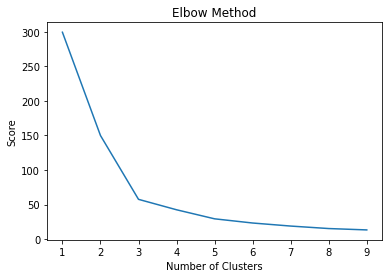

In [ ]:
num_clusters = range(1, 10)
elbow_method(num_clusters, data)

Dapat dilihat dari plot grafik tersebut, bahwa jumlah cluster yang optimum adalah k = 3.

#### **Clustering Process**
Kita akan memuat model clustering kmeans dengan 3 cluster.

In [ ]:
k = 3
kmeans_optimum = KMeansModel(k=k, max_iter = 600, random_state = 20, data=data)
fitted = kmeans_optimum.fit_data()
kmeans_prediction = kmeans_optimum.predict()

#### **Visualisasi Hasil Clustering**
Berikut visualisasi data yang telah terbagi menjadi 3 cluster beserta centroidnya

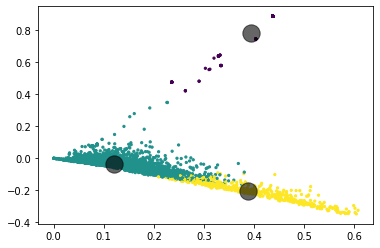

In [ ]:
kmeans_optimum.visualized_scater()

## **DBSCAN**
DBSCAN adalah algoritma clustering berdasarkan kerapatan data. Jumlah cluster akan ditentukan seiring proses learning berjalan.

In [ ]:
from sklearn.cluster import DBSCAN

class DBSCANModel():
  def __init__(self, epsilon, min_samples, data):
    self.model = DBSCAN(eps=epsilon, min_samples=min_samples)
    self.data = data

  def fit_data(self):
    self.fitted = self.model.fit(self.data)
    return(self.fitted)

  def get_clusters(self):
    self.no_clusters = len(np.unique(self.fitted.labels_))
    return(self.no_clusters)
  
  def visualized_scater(self):
    plt.scatter(self.data[:,0], self.data[:,1], s=5, c=self.fitted.labels_, cmap='viridis')
    plt.show()

### **Mencari Nilai epsilon terbaik**


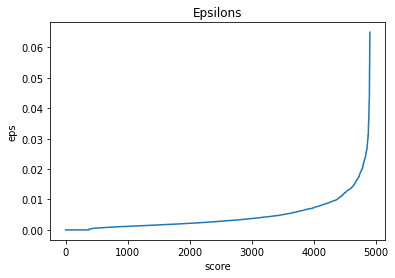

In [ ]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(data)
distances, indices = nbrs.kneighbors(data)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)
plt.xlabel('score')
plt.ylabel('eps')
plt.title('Epsilons')
plt.show()

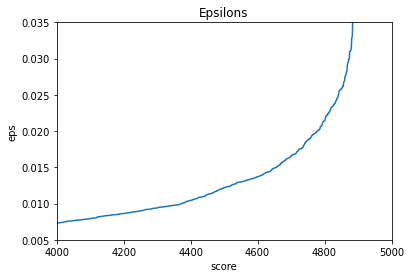

In [ ]:
plt.plot(distances)
plt.xlabel('score')
plt.ylabel('eps')
plt.title('Epsilons')
plt.axis([4000, 5000, 0.005, 0.035])
plt.show()

### **Clustering process**

In [ ]:
DBSCAN_model = DBSCANModel(0.025, 100, data)
DBSCAN_model.fit_data()

DBSCAN(eps=0.025, min_samples=100)

### **Cluster Visualization**
Berikut hasil visualisasi cluster dengan total cluster yang dihasilkan sebanyak 3

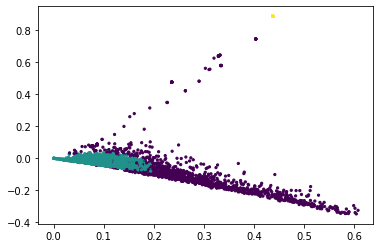

Num of clusters:  3


In [ ]:
DBSCAN_model.visualized_scater()
print("Num of clusters: ", DBSCAN_model.get_clusters())

## **Deep Embedded Clustering (DEC)**
DEC secara bersamaan mempelajari representasi feature dan melakukan assigning ke cluster menggunakan deep neural network.


In [ ]:
# Seed value (can actually be different for each attribution step)
seed_value= 0

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value) # tensorflow 2.x

# Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

### **Modelling**
Membuat model untuk autoencoder

In [ ]:
from keras.models import Model
class autoencoderModel():
    def __init__(self, dims, act='relu', init='glorot_uniform'):
      n_stacks = len(dims) - 1
      input_data = Input(shape=(dims[0],), name='input')
      x = input_data
    
      # internal layers of encoder
      for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act,  kernel_initializer=init, name='encoder_%d' % i)(x)
      encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)
      x = encoded
      
      # internal layers of decoder
      for i in range(n_stacks-1, 0, -1):
          x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)    # decoder output
      x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
      decoded = x
    
      self.autoencoder = Model(inputs=input_data, outputs=decoded, name='autoencoder')
      self.encoder = Model(inputs=input_data, outputs=encoded, name='encoder')

Dimentional reduction untuk feature dari tf-idf menjadi dense matrix dengan dimensi 100

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
data_dec = svd.fit_transform(tf_idf_vector)

#### **Create and Train Autoencoder model**
Membuat instance model autoencoder

In [ ]:
from keras.initializers import VarianceScaling
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Input
from tensorflow.keras.layers import Layer, InputSpec

n_epochs   = 100
batch_size = 128
dims = [data.shape[-1], 500, 500, 1000, 3] 
init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
pretrain_optimizer = SGD(learning_rate=1, momentum=0.9)
pretrain_epochs = n_epochs

autoencoder_model = autoencoderModel(dims, init=init)

In [ ]:
autoencoder_model.autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder_model.autoencoder.fit(data, data, batch_size=batch_size, epochs=pretrain_epochs)

Epoch 1/100
39/39 [==============================] - 2s 34ms/step - loss: 2.8108e-04
Epoch 2/100
39/39 [==============================] - 1s 32ms/step - loss: 1.6042e-04
Epoch 3/100
39/39 [==============================] - 1s 34ms/step - loss: 1.2460e-04
Epoch 4/100
39/39 [==============================] - 1s 34ms/step - loss: 1.0939e-04
Epoch 5/100
39/39 [==============================] - 1s 34ms/step - loss: 1.1481e-04
Epoch 6/100
39/39 [==============================] - 1s 32ms/step - loss: 7.7367e-05
Epoch 7/100
39/39 [==============================] - 1s 32ms/step - loss: 7.5682e-05
Epoch 8/100
39/39 [==============================] - 1s 33ms/step - loss: 6.7075e-05
Epoch 9/100
39/39 [==============================] - 1s 32ms/step - loss: 7.7826e-05
Epoch 10/100
39/39 [==============================] - 1s 31ms/step - loss: 5.5286e-05
Epoch 11/100
39/39 [==============================] - 1s 32ms/step - loss: 5.4348e-05
Epoch 12/100
39/39 [==============================] - 1s 33ms/s

### **DEC Soft Labeling**
Layer clustering yang berperan untuk melakukan soft assignment dengan bantuan auxilary target distribution.

In [ ]:
class ClusteringLayer(Layer):    
  def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
    if 'input_shape' not in kwargs and 'input_dim' in kwargs:
        kwargs['input_shape'] = (kwargs.pop('input_dim'),)
    super(ClusteringLayer, self).__init__(**kwargs)
    self.n_clusters = n_clusters
    self.alpha = alpha
    self.initial_weights = weights
    self.input_spec = InputSpec(ndim=2)
    
  def build(self, input_shape):
    assert len(input_shape) == 2
    input_dim = input_shape[1]
    self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
    self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
    
    if self.initial_weights is not None:
        self.set_weights(self.initial_weights)
        del self.initial_weights
    self.built = True
    
  def call(self, inputs, **kwargs):
    q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
    q **= (self.alpha + 1.0) / 2.0
    q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) 
    return q
  
  def compute_output_shape(self, input_shape):
    assert input_shape and len(input_shape) == 2
    return input_shape[0], self.n_clusters
  
  def get_config(self):
    config = {'n_clusters': self.n_clusters}
    base_config = super(ClusteringLayer, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [ ]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

### **Performing DEC Model**

In [ ]:
n_cluster = 3
clustering_layer = ClusteringLayer(n_cluster, name='clustering')(autoencoder_model.encoder.output)
model = Model(inputs=autoencoder_model.encoder.input, outputs=[clustering_layer, autoencoder_model.autoencoder.output])

In [ ]:
loss = 0
index = 0
maxiter = 500
update_interval = 100 
tol = 0.001

kmeans = KMeans(n_clusters=n_cluster, random_state=20)
y_pred = kmeans.fit_predict(autoencoder_model.encoder.predict(data))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

for ite in range(int(maxiter)):
  if ite % update_interval == 0:
    q, _  = model.predict(data, verbose=0)
    p = target_distribution(q)  
    y_pred = q.argmax(1)
    delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
    y_pred_last = np.copy(y_pred)
    if ite > 0 and delta_label < tol:
      print('delta_label ', delta_label, '< tol ', tol)
      print('Reached tolerance threshold. Stopping training.')
      break
  
  # reach tolerance threshold
  index_array = np.arange(data.shape[0])

  idx = index_array[index * batch_size: min((index+1) * batch_size, data.shape[0])]
  loss = model.train_on_batch(x=data[idx], y=[p[idx], data[idx]])
  index = index + 1 if (index + 1) * batch_size <= data.shape[0] else 0

#### **Using DEC model to predict**

In [ ]:
q, _ = model.predict(data, verbose=0)
p = target_distribution(q)  
y_pred = q.argmax(1)

#### **Cluster Visualization**

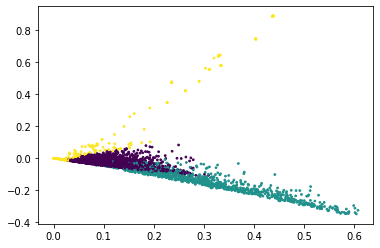

In [ ]:
plt.scatter(data[:, 0], data[:, 1],c=y_pred ,s=3, cmap='viridis')

## **Evaluasi**
Evaluasi hasil clustering ketiga model dilakukan dengan perhitungan silhouette score dan calinski harabasz score

In [ ]:
from sklearn.metrics import silhouette_score

score_kmeans = silhouette_score(data, kmeans_optimum.model.labels_, metric='euclidean')
score_dbscan = silhouette_score(data, DBSCAN_model.model.labels_, metric='euclidean')
score_dec = silhouette_score(data, y_pred, metric='euclidean')

print("silhouette k-means:", score_kmeans)
print("silhouette dbscan:", score_dbscan)
print("silhouette dec:", score_dec)



silhouette k-means: 0.73695775110582
silhouette dbscan: 0.5133440025691993
silhouette dec: 0.5028869676517486


In [ ]:
from sklearn.metrics import calinski_harabasz_score
chs_kmeans = calinski_harabasz_score(data, kmeans_optimum.model.labels_)
chs_dbscan = calinski_harabasz_score(data, DBSCAN_model.model.labels_)
chs_dec = calinski_harabasz_score(data, y_pred3)

print("chs score k-means:", chs_kmeans)
print("chs score dbscan:", chs_dbscan)
print("chs score dec:", chs_dec)

chs score k-means: 10195.032195990549
chs score dbscan: 3538.5460049708313
chs score dec: 9076.666938640208


In [ ]:
cluster0 = []
cluster1 = []
cluster2 = []

for i in range (len(notspam_emails_init)):
  if kmeans_prediction[i] == 0:
    cluster0.append(notspam_emails_init[i])
  elif kmeans_prediction[i] == 1:
    cluster1.append(notspam_emails_init[i])
  elif kmeans_prediction[i] == 2:
    cluster2.append(notspam_emails_init[i])

print("Cluster 0")
for text in cluster0:
  print(text)

print("Cluster 1")
for text in cluster1:
  print(text)

print("Cluster 2")
for text in cluster2:
  print(text)

['Subject  start date   12   25   01   hourahead hour   9    start date   12   25   01   hourahead hour   9   no ancillary schedules awarded   no variances detected    log messages    parsing file         o     portland   westdesk   california scheduling   iso final schedules   2001122509   txt', 'Subject  start date   1   5   02   hourahead hour   1    start date   1   5   02   hourahead hour   1   no ancillary schedules awarded   variances detected    variances detected in load schedule    log messages    parsing file         o     portland   westdesk   california scheduling   iso final schedules   2002010501   txt          load schedule                variance found in table tblloads    details     hour   1   preferred   36   57   final   36   54    trans   type   final  load   id   pge 2  mkt   type   2  trans   date   1   5   02  sc   id   enrj', 'Subject  start date   12   15   01   hourahead hour   20    start date   12   15   01   hourahead hour   20   no ancillary schedules aw

Save cluster ke csv untuk task selanjutnya

In [ ]:
cluster0 = []
cluster1 = []
cluster2 = []
for i in range (len(notspam_ne_removed)):
  if kmeans_prediction[i] == 0:
    cluster0.append(notspam_ne_removed[i])
  elif kmeans_prediction[i] == 1:
    cluster1.append(notspam_ne_removed[i])
  elif kmeans_prediction[i] == 2:
    cluster2.append(notspam_ne_removed[i])

In [ ]:
pd.DataFrame(cluster0).to_csv(def_path + "/cluster/cluster0_kmeans.csv")
pd.DataFrame(cluster1).to_csv(def_path + "/cluster/cluster1_kmeans.csv")
pd.DataFrame(cluster2).to_csv(def_path + "/cluster/cluster2_kmeans.csv")

In [ ]:
cluster0 = []
cluster1 = []
cluster2 = []
for i in range (len(notspam_ne_removed)):
  if y_pred[i] == 0:
    cluster0.append(notspam_ne_removed[i])
  elif y_pred[i] == 1:
    cluster1.append(notspam_ne_removed[i])
  elif y_pred[i] == 2:
    cluster2.append(notspam_ne_removed[i])

In [ ]:
pd.DataFrame(cluster0).to_csv(def_path + "/cluster/cluster0_dec.csv")
pd.DataFrame(cluster1).to_csv(def_path + "/cluster/cluster1_dec.csv")
pd.DataFrame(cluster2).to_csv(def_path + "/cluster/cluster2_dec.csv")

# Topic Modelling
*Penanggung jawab: Florencia Wijaya / 13518020*

Pada task ini, akan dilakukan topic modelling untuk mengetahui topik dari suatu cluster. Task ini dilakukan dengan unsupervised learning. 

In [ ]:
# Read clusters from csv
cluster0_csv = pd.read_csv(def_path + "/cluster/cluster0_dec.csv")
cluster1_csv = pd.read_csv(def_path + "/cluster/cluster1_dec.csv")
cluster2_csv = pd.read_csv(def_path + "/cluster/cluster2_dec.csv")

In [ ]:
cluster0_data = cluster0_csv["0"]
cluster1_data = cluster1_csv["0"]
cluster2_data = cluster2_csv["0"]

In [ ]:
def get_cluster(i):
  if(i == 0):
      return cluster0_data
  elif(i == 1):
      return cluster1_data
  elif(i == 2):
      return cluster2_data

## Data Preprocessing
Sebelum modelling, data input diproses terlebih dahulu

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# Mendefinisikan stopwords
stopwords_list = stopwords.words('english')
stopwords_list.extend([
    'from', 'subject', 're', 'hplnl', 'enron', 'etc', 'cc', 'bcc', 'ect', 'would', 'said', 'need', 'com', 
    'xls', 'hpl', 'mmbtu', 'hplno', 'hplnol', 'please', 'also', 'thanks', 'dbcaps', 'attached', 'forwarded',
    'chokshi', 'hplo', 'reveffo', 'noms', 'ggrant', 'best', 'regards', 'dear', 'vince', 'kaminski', 'unknown'])

### Tokenization
Melakukan tokenisasi setiap kalimat menjadi kumpulan kata

In [ ]:
def tokenize_text(texts):
  for text in texts:
    yield(gensim.utils.simple_preprocess(str(text), deacc=True))

### Remove stopwords
Menghapus kata-kata yang dianggap kurang memiliki arti atau tidak relevan

In [ ]:
def remove_stopwords(data):
  result = []
  for sentence in data: 
    result.append([word for word in sentence if word not in stopwords_list])
  return result

### Remove short words
Menghapus kata-kata yang panjangnya kurang dari sama dengan 4 dan random (contoh: "aa", "abab")

In [ ]:
def remove_short_words(data):
  result = []
  for sentence in data: 
    result.append([word for word in sentence if len(word) >= 4])
  return result

### Lemmatization
Mengambil kata dasar dari setiap kata

In [ ]:
def lemmatize(data):
  wordnet_lemmatizer = WordNetLemmatizer()
  result = []
  for sentence in data:
    result.append([wordnet_lemmatizer.lemmatize(word) for word in sentence])
  return result

## Dictionary and Corpus
Membuat kamus untuk setiap kata yang unik dan melakukan feature extraction dengan Bag of Words

In [ ]:
def create_dict(data_input):
  dict_result = gensim.corpora.Dictionary(data_input)

  corpus_result = [dict_result.doc2bow(data) for data in data_input]

  return dict_result, corpus_result

## Coherence Score
Menghitung skor koherensi dengan menghitung kemiripan antarkata dalam suatu topik

In [ ]:
def get_coherence_score(i, model, data, dict_input):
  coherence_model = gensim.models.CoherenceModel(model=model, texts=data, dictionary=dict_input, coherence="c_v")
  coherence_score = coherence_model.get_coherence()
  print('Coherence score for cluster ' + str(i) + ': ' + str(coherence_score))

## Latent Dirichlet Allocation (LDA)
Pada bagian ini, topic modelling dengan model LDA

### LDA Model
Membangun model LDA

In [ ]:
from pprint import pprint

In [ ]:
def create_model_lda(i, dict_lda, corpus_lda):
  # Build model
  model_lda = gensim.models.ldamodel.LdaModel(corpus=corpus_lda, id2word=dict_lda, num_topics=1)

  # Print the topic
  print('Cluster ' + str(i) + ' topic: ')
  pprint(model_lda.print_topics())

  return model_lda

### Predict the topic for all clusters
Memprediksi topik dari semua cluster

In [ ]:
for i in range(3):
  cluster_input = get_cluster(i)

  data_lda = list(tokenize_text(cluster_input))
  data_lda = remove_stopwords(data_lda)
  data_lda = remove_short_words(data_lda)
  data_lda = lemmatize(data_lda)

  dict_lda, corpus_lda = create_dict(data_lda)

  model_lda = create_model_lda(i, dict_lda, corpus_lda)

  get_coherence_score(i, model_lda, data_lda, dict_lda)

Cluster 0 topic: 
[(0,
  '0.005*"message" + 0.005*"power" + 0.004*"deal" + 0.004*"sent" + '
  '0.004*"energy" + 0.004*"market" + 0.004*"time" + 0.004*"know" + '
  '0.004*"business" + 0.003*"original"')]
Coherence score for cluster 0: 0.2433194738713619
Cluster 1 topic: 
[(0,
  '0.052*"schedule" + 0.044*"data" + 0.042*"database" + 0.036*"hourahead" + '
  '0.035*"date" + 0.029*"start" + 0.028*"unknown" + 0.028*"alias" + '
  '0.025*"final" + 0.020*"file"')]
Coherence score for cluster 1: 0.7519855856975999
Cluster 2 topic: 
[(0,
  '0.011*"company" + 0.007*"deal" + 0.005*"energy" + 0.005*"trading" + '
  '0.005*"market" + 0.005*"dynegy" + 0.004*"price" + 0.004*"know" + '
  '0.004*"stock" + 0.004*"time"')]
Coherence score for cluster 2: 0.3462798436809188


## Latent Semantic Analysis/Indexing (LSA/LSI)

In [ ]:
from gensim.models import LsiModel

### Feature Extraction (TF-IDF)
Melakukan feature extraction dengan TF-IDF

In [ ]:
def create_tfidf(corpus):
  tfidf = gensim.models.TfidfModel(corpus)
  corpus_tfidf = tfidf[corpus]
  return corpus_tfidf

### LSI Model
Membangun model LSI

In [ ]:
def create_model_lsi(i, dict_lsi, corpus_lsi):
  # Build model
  model_lsi = gensim.models.lsimodel.LsiModel(corpus=corpus_lsi, id2word=dict_lsi, num_topics=1)

  # Print the topic
  print('Cluster ' + str(i) + ' topic: ')
  pprint(model_lsi.print_topics())

  return model_lsi

### Predict the topic for all clusters
Memprediksi topik dari semua cluster

In [ ]:
for i in range(3):
  cluster_input = get_cluster(i)

  data_lsi = list(tokenize_text(cluster_input))
  data_lsi = remove_stopwords(data_lsi)
  data_lsi = remove_short_words(data_lsi)
  data_lsi = lemmatize(data_lsi)

  dict_lsi, corpus_lsi = create_dict(data_lsi)

  corpus_tfidf = create_tfidf(corpus_lsi)

  model_lsi = create_model_lsi(i, dict_lsi, corpus_tfidf)

  get_coherence_score(i, model_lsi, data_lsi, dict_lsi)

Cluster 0 topic: 
[(0,
  '-0.959*"file" + -0.042*"revision" + -0.042*"deal" + -0.037*"call" + '
  '-0.035*"change" + -0.035*"question" + -0.033*"company" + -0.029*"market" + '
  '-0.028*"energy" + -0.028*"report"')]
Coherence score for cluster 0: 0.21098413866451518
Cluster 1 topic: 
[(0,
  '0.309*"variance" + 0.309*"detected" + 0.309*"ancillary" + 0.309*"awarded" + '
  '0.309*"parsing" + 0.295*"final" + 0.295*"message" + 0.295*"westdesk" + '
  '0.295*"scheduling" + 0.295*"portland"')]
Coherence score for cluster 1: 0.46743064384264493
Cluster 2 topic: 
[(0,
  '0.356*"deal" + 0.313*"meter" + 0.213*"ticket" + 0.170*"aimee" + '
  '0.129*"volume" + 0.124*"farmer" + 0.119*"production" + 0.115*"equistar" + '
  '0.111*"vance" + 0.111*"contract"')]
Coherence score for cluster 2: 0.4677589791271747


## Lda2Vec
Pada bagian ini, topic modelling dilakukan menggunakan Lda2Vec

In [ ]:
import tensorflow as tf

In [ ]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

In [ ]:
!pip uninstall lda2vec

Found existing installation: lda2vec 0.16.10
Uninstalling lda2vec-0.16.10:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/lda2vec-0.16.10.dist-info/*
    /usr/local/lib/python3.7/dist-packages/lda2vec/*
Proceed (y/n)? y
  Successfully uninstalled lda2vec-0.16.10


In [ ]:
!pip install git+https://github.com/annaelvira24/Lda2vec-Tensorflow.git

  Cloning https://github.com/annaelvira24/Lda2vec-Tensorflow.git to /tmp/pip-req-build-7otyqsvw
  Running command git clone -q https://github.com/annaelvira24/Lda2vec-Tensorflow.git /tmp/pip-req-build-7otyqsvw


In [ ]:
!pip install tf-slim

In [ ]:
!pip install pyLDAvis==2.1.2

In [ ]:
from lda2vec.nlppipe import Preprocessor
from lda2vec import utils, model

Instructions for updating:
non-resource variables are not supported in the long term


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


### Preprocess LDA2Vec
Melakukan preprocess bawaan dari LDA2Vec

In [ ]:
def preprocess_lda2vec(df):
  # Where to save preprocessed data
  clean_data_dir = def_path

  # Should we load pretrained embeddings from file
  load_embeds = True

  # Initialize a preprocessor
  P = Preprocessor(df, "0", max_features=30000, maxlen=10000, min_count=30)

  # Run the preprocessing on your dataframe
  P.preprocess()

  # Load embeddings from file if we choose to do so
  if load_embeds:
      # Load embedding matrix from file path - change path to where you saved them
      embedding_matrix = P.load_glove(def_path + "glove.6B.50d.txt")
  else:
      embedding_matrix = None

  # Save data to data_dir
  P.save_data(clean_data_dir, embedding_matrix=embedding_matrix)

### Model LDA2Vec
Membangun model LDA2Vec

In [ ]:
def build_model(word_name, topic_name, optimizer_name):
  # Path to preprocessed data
  data_path  = def_path
  # Whether or not to load saved embeddings file
  load_embeds = True

  # Load data from files
  (idx_to_word, word_to_idx, freqs, pivot_ids,
  target_ids, doc_ids, embed_matrix) = utils.load_preprocessed_data(data_path, load_embed_matrix=load_embeds)

  # Number of unique documents
  num_docs = doc_ids.max() + 1
  # Number of unique words in vocabulary (int)
  vocab_size = len(freqs)
  # Embed layer dimension size
  # If not loading embeds, change 128 to whatever size you want.
  embed_size = embed_matrix.shape[1] if load_embeds else 128
  # Number of topics to cluster into
  num_topics = 1
  # Amount of iterations over entire dataset
  num_epochs = 10
  # Batch size - Increase/decrease depending on memory usage
  batch_size = 64
  # Epoch that we want to "switch on" LDA loss
  switch_loss_epoch = 0
  # Pretrained embeddings value
  pretrained_embeddings = embed_matrix if load_embeds else None
  # If True, save logdir, otherwise don't
  save_graph = False


  # Initialize the model
  m = model(num_docs,
            vocab_size,
            num_topics,
            embedding_size=embed_size,
            pretrained_embeddings=pretrained_embeddings,
            freqs=freqs,
            word_embedding_name = word_name,
            topic_embedding_name = topic_name,
            optimizer_name = optimizer_name,
            batch_size = batch_size,
            save_graph_def=save_graph)

  # Train the model
  m.train(pivot_ids,
          target_ids,
          doc_ids,
          len(pivot_ids),
          num_epochs,
          idx_to_word=idx_to_word,
          switch_loss_epoch=switch_loss_epoch)

### Predict the topic for all clusters
Memprediksi topik dari semua cluster




In [ ]:
def get_cluster_lda2vec(i):
  if(i == 0):
      return cluster0_data_2
  elif(i == 1):
      return cluster1_data_2
  elif(i == 2):
      return cluster2_data_2

In [ ]:
# Read clusters from csv
cluster0_csv_2 = pd.read_csv(def_path + "/cluster/cluster0_dec.csv")
cluster1_csv_2 = pd.read_csv(def_path + "/cluster/cluster1_dec.csv")
cluster2_csv_2 = pd.read_csv(def_path + "/cluster/cluster2_dec.csv")

In [ ]:
cluster0_data_2 = cluster0_csv_2["0"]
cluster1_data_2 = cluster1_csv_2["0"]
cluster2_data_2 = cluster2_csv_2["0"]

In [ ]:
for i in range(2):
  tf.compat.v1.reset_default_graph()
  print("Cluster " + str(i))
  cluster_input = get_cluster_lda2vec(i)

  data_lda2vec = list(tokenize_text(cluster_input))
  data_lda2vec = remove_stopwords(data_lda2vec)
  data_lda2vec = remove_short_words(data_lda2vec)
  data_lda2vec = lemmatize(data_lda2vec)

  join_data_lda2vec = []
  for sentence in data_lda2vec:
    join_sentence_lda2vec = " ".join([word for word in sentence])
    join_data_lda2vec.append(join_sentence_lda2vec)

  dataframe_lda2vec = pd.DataFrame(join_data_lda2vec, columns=["0"])

  preprocess_lda2vec(dataframe_lda2vec)

  build_model("cluster-word-embed" + str(i), "cluster-topic" + str(i), "cluster-optimizer" + str(i))

Cluster 0

---------- Tokenizing Texts ----------


3261it [00:12, 270.79it/s]


Removing 16836 low frequency tokens out of 18465 total tokens

---------- Getting Skipgrams ----------


3261it [00:07, 420.62it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



EPOCH: 1
LOSS 4.32266 w2v 4.32266 lda 0.0

EPOCH: 2
LOSS 4.3476768 w2v 4.3476768 lda 0.0

EPOCH: 3
LOSS 4.1550236 w2v 4.1550236 lda 0.0

EPOCH: 4
LOSS 4.4232917 w2v 4.4232917 lda 0.0

EPOCH: 5
LOSS 4.2544384 w2v 4.2544384 lda 0.0
---------Closest 10 words to given indexes----------
Topic 0 : donoho, lindy, lohman, belden, teco, lindberg, steffes, tammie, pefs, shively

EPOCH: 6
LOSS 4.1326394 w2v 4.1326394 lda 0.0

EPOCH: 7
LOSS 4.0017824 w2v 4.0017824 lda 0.0

EPOCH: 8
LOSS 4.2415657 w2v 4.2415657 lda 0.0

EPOCH: 9
LOSS 4.135011 w2v 4.135011 lda 0.0

EPOCH: 10
LOSS 4.4659023 w2v 4.4659023 lda 0.0
---------Closest 10 words to given indexes----------
Topic 0 : donoho, lindy, pefs, lohman, redeliveries, waha, airmail, teco, steffes, shively
Cluster 1

---------- Tokenizing Texts ----------


504it [00:00, 676.61it/s]


Removing 1593 low frequency tokens out of 1643 total tokens

---------- Getting Skipgrams ----------


504it [00:00, 2267.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



EPOCH: 1
LOSS 3.5730512 w2v 3.5730512 lda 0.0

EPOCH: 2
LOSS 3.3194609 w2v 3.3194609 lda 0.0

EPOCH: 3
LOSS 3.3161027 w2v 3.3161027 lda 0.0

EPOCH: 4
LOSS 3.4005897 w2v 3.4005897 lda 0.0

EPOCH: 5
LOSS 3.331366 w2v 3.331366 lda 0.0
---------Closest 10 words to given indexes----------
Topic 0 : alias, unknown, database, ancillary, closed, parsing, start, portland, detected, file

EPOCH: 6
LOSS 3.4120908 w2v 3.4120908 lda 0.0

EPOCH: 7
LOSS 3.4183102 w2v 3.4183102 lda 0.0

EPOCH: 8
LOSS 3.281226 w2v 3.281226 lda 0.0

EPOCH: 9
LOSS 3.2734153 w2v 3.2734153 lda 0.0

EPOCH: 10
LOSS 3.242642 w2v 3.242642 lda 0.0
---------Closest 10 words to given indexes----------
Topic 0 : alias, unknown, database, ancillary, crawler, portland, closed, failure, parsing, trans


# **MAIN PROGRAM**

## **Spam Classification**

In [ ]:
import pickle
data = pd.read_csv(def_path + 'test_data.csv')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
#preprocess to tf idf

vectorizer = pickle.load(open(def_path + 'spam_features.sav', 'rb'))
tfidf = vectorizer.transform(data['sent'])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
# load the model from disk
loaded_model = pickle.load(open(def_path + 'spam_model.sav', 'rb'))
result = loaded_model.predict(tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator SGDClassifier from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
# print score
print(f1_score(result, data['Label']))
print(precision_score(result, data['Label']))
print(recall_score(result, data['Label']))

data['predict'] = result

0.9949674984273432
0.9968487394957983
0.9930933444956048


In [ ]:
nonspam_data = (data.loc[data['predict'] == 0]).drop('Label', axis=1)

In [ ]:
nonspam_data.head()

,sent,predict
37,Subject important requested file,0
416,Subject new accts exclusive free ebooks s...,0
736,Subject,0
738,Subject nymex invitation learn power tradin...,0
766,Subject would you like a 250 gas card do...,0


## **Text Clustering**

In [ ]:
notspam_ne_removed_test = preprocess_clustering(nonspam_data["sent"])

In [ ]:
tf_idf_vector_test = tf_idf_clustering(notspam_ne_removed_test)
data_test = dimension_reduction(tf_idf_vector_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  % sorted(inconsistent)


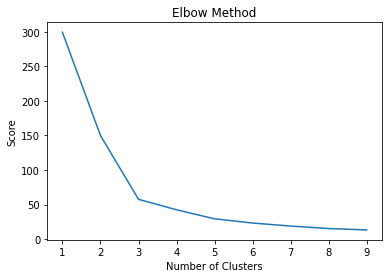

In [ ]:
num_clusters = range(1, 10)
elbow_method(num_clusters, data_test)

0.7370075596948695


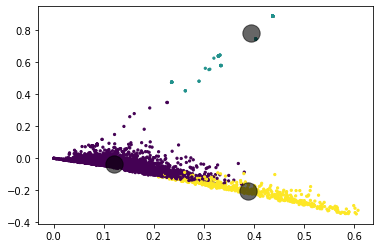

In [ ]:
k = 3
kmeans_optimum_test = KMeansModel(k=k, max_iter = 600, random_state = 20, data=data_test)
fitted = kmeans_optimum_test.fit_data()
kmeans_prediction_test = kmeans_optimum_test.predict()

kmeans_optimum_test.visualized_scater()
print(silhouette_score(data_test, kmeans_optimum_test.model.labels_, metric='euclidean'))

In [ ]:
data_test_temp = np.array(nonspam_data["sent"])
cluster0 = []
cluster1 = []
cluster2 = []

for i in range (len(data_test_temp)):
  if kmeans_prediction_test[i] == 0:
    cluster0.append(data_test_temp[i])
  elif kmeans_prediction_test[i] == 1:
    cluster1.append(data_test_temp[i])
  elif kmeans_prediction_test[i] == 2:
    cluster2.append(data_test_temp[i])

print("Cluster 0")
for text in cluster0[1:100]:
  print(text)

print("\nCluster 1")
for text in cluster1[1:100]:
  print(text)

print("\nCluster 2")
for text in cluster2[1:100]:
  print(text)

Cluster 0
Subject  new accts   exclusive free ebooks   software   and 300   bonus  function        var cookiename     combinedpop      var count   getcookie   cookiename      if   count     null      count   1    setcookie   cookiename   count   exp      var url     http       www   casinoblasters   com   marketing   tools   exitpop   exit   php   member   marketexpress      var windowwidth   454    var windowheight   324    var windowtop     screen   availheight   2       windowheight   2      var windowleft     screen   availwidth   2       windowwidth   2      var windowprops     toolbar   0   location   0   status   0   menubar   0   scrollbars   0   resizable   width       windowwidth       height       windowheight       left       windowleft       top       windowtop       screenx       windowleft       screeny       windowtop    cbexitwindow   window   open   url     cbexitwindow     windowprops                the cookie functions follow          function getcookie   popup     

## **Topic Modeling**

In [ ]:
cluster0_data = cluster0
cluster1_data = cluster1
cluster2_data = cluster2

In [ ]:
for i in range(3):
  cluster_input = get_cluster(i)

  data_lda = list(tokenize_text(cluster_input))
  data_lda = remove_stopwords(data_lda)
  data_lda = remove_short_words(data_lda)
  data_lda = lemmatize(data_lda)

  dict_lda, corpus_lda = create_dict(data_lda)

  model_lda = create_model_lda(i, dict_lda, corpus_lda)

  get_coherence_score(i, model_lda, data_lda, dict_lda)

Cluster 0 topic: 
[(0,
  '0.005*"company" + 0.004*"power" + 0.004*"energy" + 0.004*"know" + '
  '0.004*"time" + 0.004*"year" + 0.004*"business" + 0.004*"message" + '
  '0.004*"deal" + 0.004*"information"')]
Coherence score for cluster 0: 0.23261375003746537
Cluster 1 topic: 
[(0,
  '0.098*"schedule" + 0.079*"hourahead" + 0.073*"date" + 0.073*"hour" + '
  '0.070*"start" + 0.047*"final" + 0.038*"variance" + 0.036*"detected" + '
  '0.033*"westdesk" + 0.033*"scheduling"')]
Coherence score for cluster 1: 0.6807107263462885
Cluster 2 topic: 
[(0,
  '0.012*"corp" + 0.009*"deal" + 0.007*"meter" + 0.005*"know" + 0.005*"daren" '
  '+ 0.004*"robert" + 0.004*"group" + 0.004*"farmer" + 0.004*"time" + '
  '0.003*"development"')]
Coherence score for cluster 2: 0.22512100107135463
